<a href="https://colab.research.google.com/github/alejandrods/Noise-Regularization-Method-Neural-Network/blob/master/Adding_Noise_Deep_Learning_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

One of the first concepts you learn when you are beginning to study neural networks is the meaning of __overfitting__ or __underfitting__. Many times, it is a challenge to train a model that generalize perfectly your data, especially when you have a small dataset because:

- When you train a neural network with small datasets, generally the network memorizes the training dataset instead of learning general features of our data. For this reason, the model will perform well on the training set and poor on new data (for instance: the test dataset)

- A small dataset provides a poor description of our problem and thus, it may result in a difficult problem to learn.

To acquire more data it is a very expensive and arduous task. However, sometimes you can __apply some techniques (regularization methods) to get a better performance in your model.__

In this talk, we are focusing on the use of noise as a regularizing method in a neural network. This technique not only reduces overfitting, but it can also lead to faster optimization of our model better overall performance.

## Goals
The objectives of this talk are the following:
- Generate synthetic data using sklearn.
- Train a basic Neural Network as a baseline.
- Use noise as regularization method - input layer
- Use noise as regularization method - hidden layer
- Use noise as regularization method - input and hidden layer
- Grid Search to find the values for the best performance of the model.

Additionally, we will learn to create a grid to evaluate many points at the same time and check how our model classifies these points plotting a heat-map.

## 1 - Generating data using Sklearn

We want to understand the effect of using noise as a regularization method in a neural network with overfitting and we have decided to use a binary classification problem to explain this. Therefore we are going to generate a binary dataset applying sklearn, specifically `make_circles` which generates 2 two-dimensional concentric circles. The parameters are:

- `n_samples=100` (The total number of points generated)
- `noise=0.09` (Standard deviation of Gaussian noise added to the data)
- `param_random=24` (Pass an int for reproducible output across multiple function calls)

In [1]:
from sklearn.datasets import make_circles

from pandas import DataFrame
import numpy as np
import scipy.stats as stats
import math

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras.layers import Dense, GaussianNoise, Activation
from keras.models import Sequential

# Define seed
np.random.seed(42)

Using TensorFlow backend.


In [0]:
# Define Parameters
n_samples = 100
param_noise = 0.1
param_random = 1

# Create Data
X_train, y_train = make_circles(n_samples=n_samples, 
                                noise=param_noise, 
                                random_state=param_random)

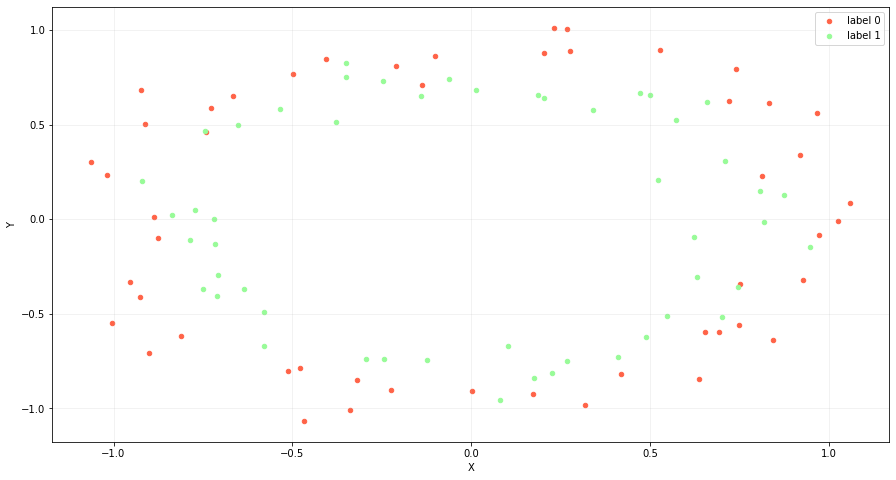

In [0]:
# Plot data
# We group the data
df = DataFrame(dict(X=X_train[:,0], Y=X_train[:,1], label=y_train))
colors = {0:'tomato', 1:'palegreen'}
fig, ax = plt.subplots(figsize=(15, 8))
grouped = df.groupby('label')

# For each group, we add it
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='X', y='Y', s=20, label='label ' + str(key), color=colors[key])
plt.grid(alpha=0.2)
plt.show()

Our data has the following structure:

In [0]:
df.head(5)

,X,Y,label
0,-0.636405,-0.368702,1
1,-0.244660,-0.736592,1
2,-0.465971,-1.066877,0
3,-0.709998,-0.408419,1
4,0.702322,-0.517301,1


We need to evaluate the performance of our network to see if we have overfitting thus, we need to split our data to generate another dataset (`x_test`) for testing. We have split our data into `train_set` (30%) and `test_set` (70%).

As we need to force overfitting, we have chosen a small size (30%) for our train set because we want to create a neural network that doesn't generalize our data and has a higher error on the test dataset.

In [0]:
# Percentage for test
test_perc = 0.7

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, 
                                                    test_size=test_perc, 
                                                    random_state=42)

print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("")
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (30, 2)
Shape of y_train:  (30,)

Shape of X_test:  (70, 2)
Shape of y_test:  (70,)


We can plot how is the distribution of `X_train` and `X_test` 

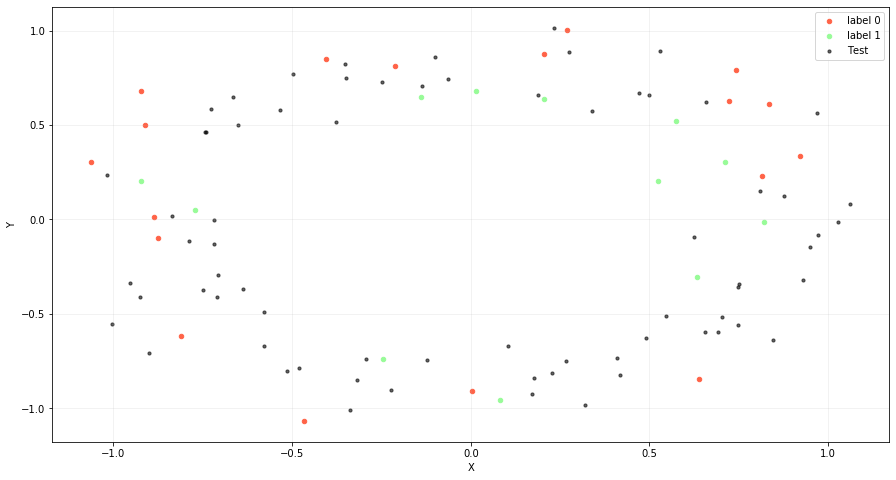

In [0]:
# We define a dataframe to group our data into 2 classes
df = DataFrame(dict(X=X_train[:,0], Y=X_train[:,1], label=y_train))
# Define color for each label
colors = {0:'tomato', 1:'palegreen'}
fig, ax = plt.subplots(figsize=(15, 8))
grouped = df.groupby('label')

# For each group, we plot it
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='X', y='Y', s=20, label='label ' + str(key), color=colors[key])

plt.scatter(X_test[:,0], X_test[:, 1], s=10, c='black', alpha=0.6, marker='o', label='Test')
plt.grid(alpha=0.2)
plt.legend()

plt.show()

We have selected this kind of data, called __circle data__ because these classes are __not linearly separable__ (we can not split our data using a line). For this reason, we need a neural network to address this nonlinear problem.

As we need to find overfitting in our model to study the effect of the noise as a regularizing method, we have only generated 100 samples. This is a small size to train a neural network and it enables us to overfit the training.

## 2.- Basic Neural Network

To study how noise influences our training, we have trained a basic Neural Network as a baseline. We have defined a Multilayer Perceptron to address our binary classification problem.

The first layer is a hidden layer that uses `400 nodes` and the `relu` activation function. In the output layer, we have used a `sigmoid` because we want to predict class values of 0 or 1. We use `binary_crossentropy` as loss (proper for binary classifications) and `adam` as optimizer.

We train the neural network for `5000 epochs` and we use `X_test` and `y_test` as validation_data.

In [0]:
# Create model
model_basic = Sequential()
model_basic.add(Dense(400, input_dim = X_train.shape[1], activation='relu'))
model_basic.add(Dense(1, activation='sigmoid'))
model_basic.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_basic.summary()

# Train model
hist_basic = model_basic.fit(X_train, y_train, 
                             validation_data=(X_test, y_test),
                             epochs=5000, 
                             verbose=0)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 400)               1200      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 401       
Total params: 1,601
Trainable params: 1,601
Non-trainable params: 0
_________________________________________________________________










In [0]:
# Evaluate the model with train and test sets
_, train_acc_basic = model_basic.evaluate(X_train, y_train, verbose=0)
_, test_acc_basic = model_basic.evaluate(X_test, y_test, verbose=0)

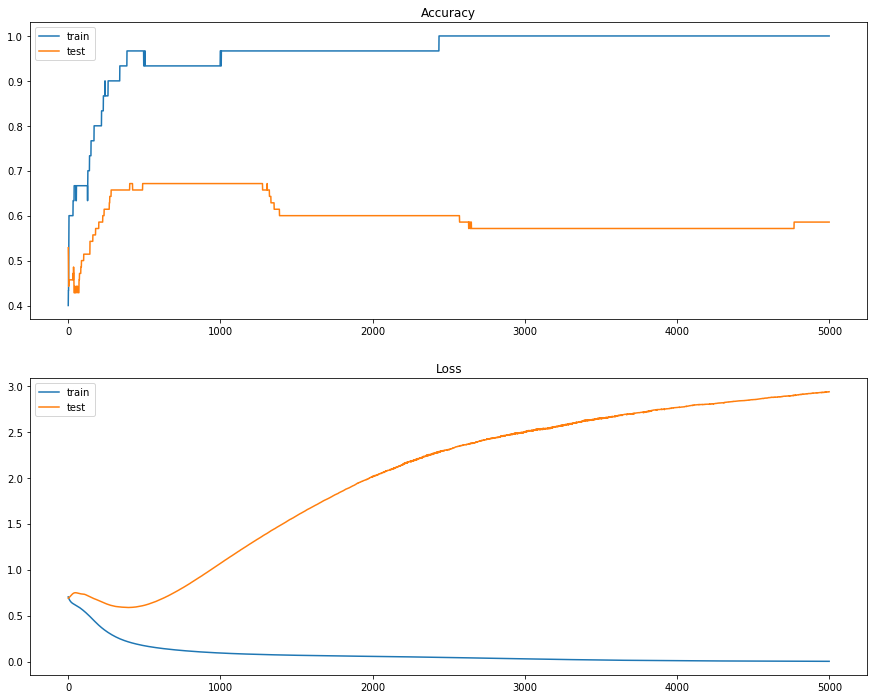

In [0]:
fig, axs = plt.subplots(2, figsize=(15, 12))

axs[0].plot(hist_basic.history['acc'], label='train')
axs[0].plot(hist_basic.history['val_acc'], label='test')
axs[0].title.set_text('Accuracy')
axs[0].legend()

axs[1].plot(hist_basic.history['loss'], label='train')
axs[1].plot(hist_basic.history['val_loss'], label='test')
axs[1].title.set_text('Loss')
axs[1].legend()

plt.show()

We have plotted a graph to represent the accuracy and loss on train and test set. It can be observed that our neural network has overfitting because this graph has the expected shape of an overfit model, `test accuracy` increases to a point and then begins to decrease again. At the same time, `loss` is divergent.

### Save result

We are going to create a dataframe to store the results of our experiment, this enables us to compare the results easier.

In [0]:
# Insert results in dataframe
df_results = DataFrame({'Experiment': ['Basic Neural Network'], 
                'train_acc': [train_acc_basic],
                'test_acc': [test_acc_basic]})

df_results.head()

,Experiment,train_acc,test_acc
0,Basic Neural Network,1.0,0.585714


### Heat-map Result

We are going to use a heat-map to plot how our model classifies the data, we have defined a function to create this graph. First of all, we need to initialize a `linspace array` for the __x-axis__ and another one for the __y-axis__ with `res=200`, which is the number of samples to generate (by default). Finally, we define a matrix of zeros `_y_train` to fill in with the result of `model.predict`.

In [0]:
def heat_map_predict(model_pred, x_lim, y_lim, n_points=200):
  """
  Function to plot a heat-map using a matrix of NxM for evaluate our model 
  :param model_pred: model for prediction
  :param x_lim: limit for the linspace array for x axis, [float, float] 
  :param y_lim: limit for the linspace array for y axis, [float, float] 
  :param n_points: number of points 
  """

  # Create grid
  x_plot = np.linspace(x_lim[0], x_lim[1], n_points)
  y_plot = np.linspace(y_lim[0], y_lim[1], n_points)

  # Matrix of zeros to store our prediction for each point
  _y_train = np.zeros((n_points, n_points))

  # For each point in our grid
  for i0, x0 in enumerate(x_plot):
    for i1, x1 in enumerate(y_plot):
      # We evaluate the point x0, x1 and save result in _y_train
      _y_train[i0, i1] = model_pred.predict(np.array([x0, x1])[np.newaxis, :])[0][0]

  # Plot again our groups of data
  df = DataFrame(dict(X=X_train[:,0], Y=X_train[:,1], label=y_train))
  colors = {0:'salmon', 1:'skyblue'}
  fig, ax = plt.subplots(figsize=(15, 8), dpi= 80)

  # Plot the grid.
  plt.pcolormesh(x_plot, y_plot, _y_train, cmap="coolwarm")

  # For each group, we add it
  for key, group in grouped:
      group.plot(ax=ax, kind='scatter', x='X', y='Y', s=12, label=key, color=colors[key])

  # Plot the test_set
  plt.scatter(X_test[:,0], X_test[:, 1], s=10, c='black', alpha=0.6, marker='o',label='Test data')
  plt.grid(alpha=0.2)
  plt.legend()

  plt.show()
  return

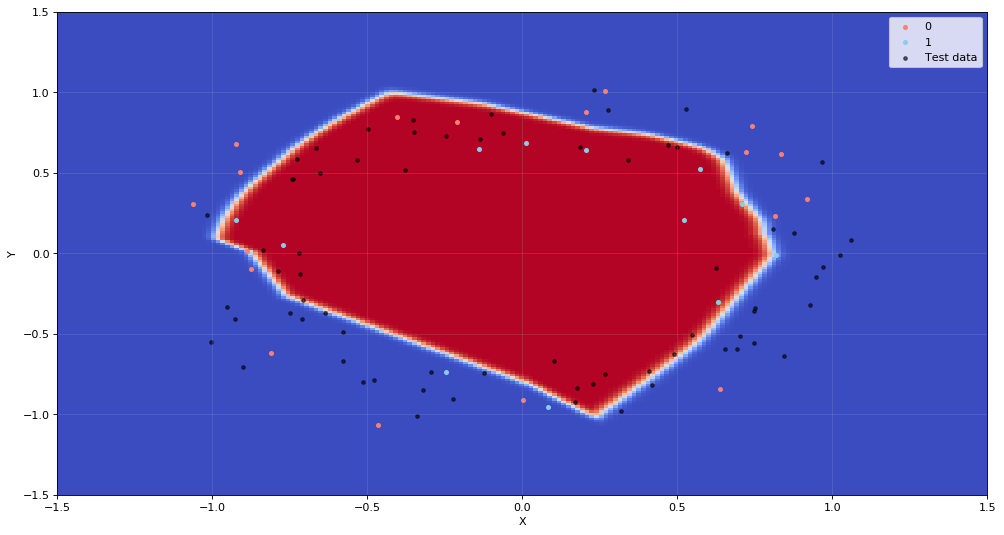

In [0]:
heat_map_predict(model_basic, x_lim=[-1.5, 1.5], y_lim=[-1.5, 1.5])

We can observe that the accuracy for the __train set__ is about `train_acc=1` and for the test set is about `test_acc=0.5857`. It has better performance on the training set than the test dataset, this can be a sign for overfitting.

Furthermore, if we see the heat-map figure above, it seems that the model has not learned to generalize very well. The model doesn't split the data correctly.

Now, we are going to add noise using the `Gaussian Noise Layer` from Keras and compare the results. This layer applies additive zero-centered Gaussian noise, which is useful to mitigate overfitting. __Gaussian Noise (GS) is a natural choice as a corruption process for real-valued inputs.__

> __IMPORTANT:__ This regularization layer, is only active at training time.

## 3.- But what is Gaussian Noise?

Gaussian Noise is statistical noise having a probability density function equal to that of the normal distribution. It is also known as the Gaussian Distribution:

The probability density function ${p}$ of a Gaussian random variable ${z}$ is given by:

$p_{G}(z)={\frac  {1}{\sigma {\sqrt  {2\pi }}}}e^{{-{\frac  {(z-\mu )^{2}}{2\sigma ^{2}}}}}$


where ${z}$ represents the grey level, ${\mu }$ the mean value and ${\sigma}$ the standard deviation. To sum up, the values that the noise can take on are Gaussian-distributed.

To understand the meaning of Gaussian Noise, imagine that we have an image and we have plotted 2 Probability Density Functions. If we observe the red PDF: __the mean value of the noise will be -2__. So, on average, 2 would be subtracted from all pixels of the image. However, if we observe the orange PDF, __the mean value is 3__. So on average, 3 would be added to all pixels.

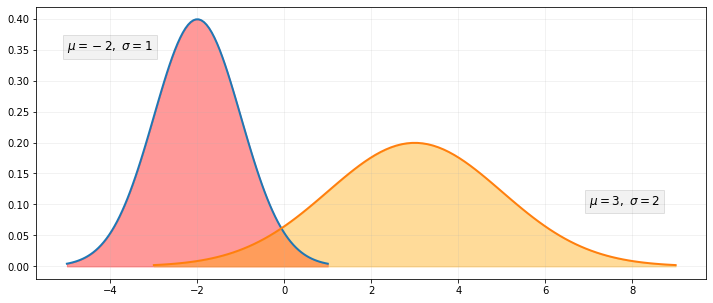

In [0]:
# Define the first Probability Density Function
mu_1 = -2
sigma_1 = 1
x_range_1 = np.linspace(mu_1 - 3*sigma_1, mu_1 + 3*sigma_1, 100)

plt.figure(figsize=(12, 5))
plt.plot(x_range_1, stats.norm.pdf(x_range_1, mu_1, sigma_1), linewidth=2)
plt.fill_between(x_range_1, stats.norm.pdf(x_range_1, mu_1, sigma_1), color='red', alpha=0.4)
plt.text(-5, .35, r'$\mu=-2,\ \sigma=1$', fontsize=12, bbox=dict(facecolor='grey', alpha=0.1))
plt.grid(alpha=0.2)

# Define the second Probability Density Function
mu_2 = 3
sigma_2 = 2
x_range_2 = np.linspace(mu_2 - 3*sigma_2, mu_2 + 3*sigma_2, 100)

plt.plot(x_range_2, stats.norm.pdf(x_range_2, mu_2, sigma_2), linewidth=2)
plt.fill_between(x_range_2, stats.norm.pdf(x_range_2, mu_2, sigma_2), color='orange', alpha=0.4)
plt.text(7, .10, r'$\mu=3,\ \sigma=2$', fontsize=12, bbox=dict(facecolor='grey', alpha=0.1))
plt.grid(alpha=0.2)

plt.show()

For instance, if we take this image and we apply Gaussian Noise:


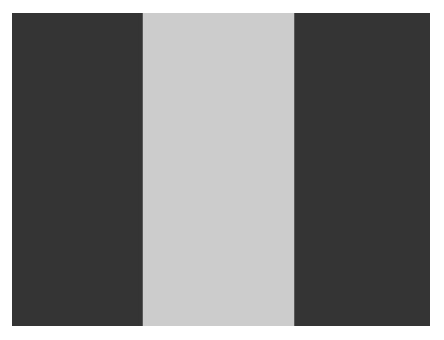

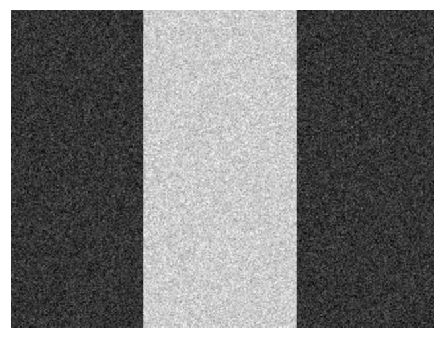

In [2]:
import cv2

img = cv2.imread('/content/gaussian_img.png')
plt.figure(figsize=(10,6))
plt.xlabel("NORMAL IMAGE")
plt.axis('off')
plt.imshow(img)

img = cv2.imread('/content/gaussian_img_noise.png')
plt.figure(figsize=(10,6))
plt.xlabel("GAUSSIAN NOISE")
plt.axis('off')
plt.imshow(img)

We can check the histogram for each image:

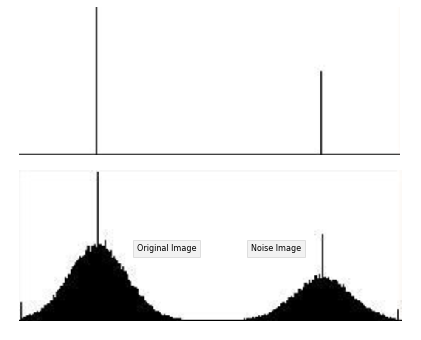

In [3]:
img = cv2.imread('/content/gaussian_noise_hist.png')
plt.figure(figsize=(10,6))
plt.xlabel("HISTOGRAM")
plt.axis('off')
plt.text(175, 330, r'Original Image', fontsize=8, bbox=dict(facecolor='grey', alpha=0.1))
plt.text(330, 330, r'Noise Image', fontsize=8, bbox=dict(facecolor='grey', alpha=0.1))
plt.imshow(img) 

Although we have explained the Gaussian Noise with images, the method of applying Gaussian Noise as regularization methods in Keras is the same theory.

Adding noise increases the size of our training dataset. When we are training a neural network, random noise is added to each training sample and this is a form of data augmentation. Furthermore, when we use noise, we are increasing the randomness of our data and the model is less capable to learn training samples since they are changing each iteration. Consequently, the neural network learns more general features and has lower generalization errors.

When we are applying noise, we are creating new samples in the vicinity of the training samples thus, the distribution of the input data is smoothed.  This allows the neural network to learn easier our data.

## 4.- Neural Network with Input Layer Noise

We will add a Gaussian Noise layer as the input layer and we are going to analyze if this helps to improve generalization performance. When we add noise we are creating more samples and making the distribution of data smoother.

In [0]:
# Create model
model_noise_in = Sequential()
# GaussianLayer with standard deviation of 0.1
model_noise_in.add(GaussianNoise(0.1, input_shape=(2,)))
model_noise_in.add(Dense(400, activation='relu'))
model_noise_in.add(Dense(1, activation='sigmoid'))
model_noise_in.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_noise_in.summary()

# Train model
hist_noise_in = model_noise_in.fit(X_train, y_train, 
                                   validation_data=(X_test, y_test),
                                   epochs=5000, verbose=0)



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_1 (GaussianNo (None, 2)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 400)               1200      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 401       
Total params: 1,601
Trainable params: 1,601
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Evaluate the model with train and test sets
_, train_acc_noise = model_noise_in.evaluate(X_train, y_train, verbose=0)
_, test_acc_noise = model_noise_in.evaluate(X_test, y_test, verbose=0)

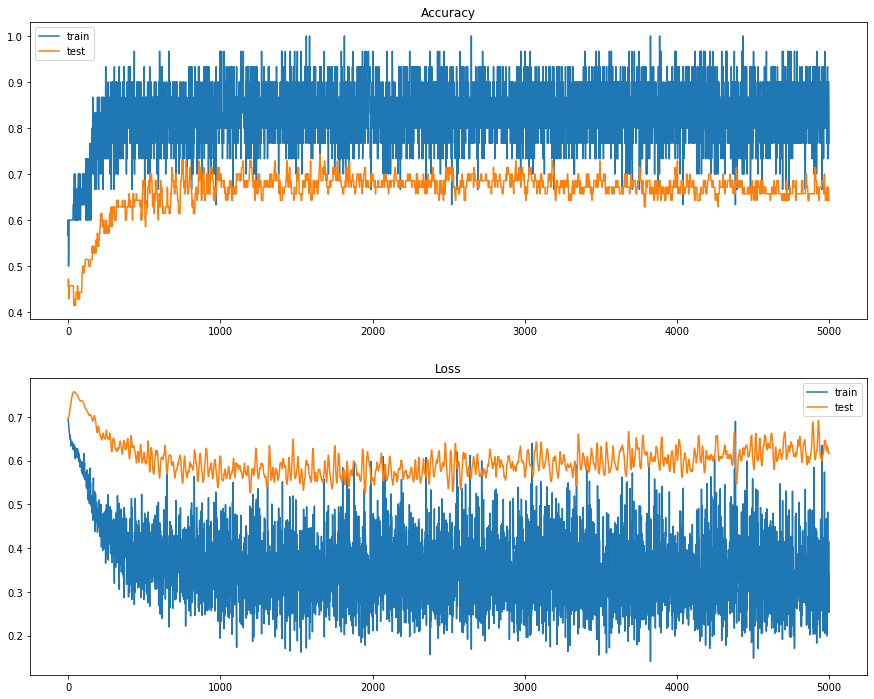

In [0]:
fig, axs = plt.subplots(2, figsize=(15, 12))

axs[0].plot(hist_noise_in.history['acc'], label='train')
axs[0].plot(hist_noise_in.history['val_acc'], label='test')
axs[0].title.set_text('Accuracy')
axs[0].legend()

axs[1].plot(hist_noise_in.history['loss'], label='train')
axs[1].plot(hist_noise_in.history['val_loss'], label='test')
axs[1].title.set_text('Loss')
axs[1].legend()

plt.show()

### Save result

In [0]:
# Insert results in dataframe
df_results_noise = DataFrame({'Experiment': ['Input Noise Neural Network'], 
                'train_acc': [train_acc_noise],
                'test_acc': [test_acc_noise]})

df_results = df_results.append(df_results_noise)

In [0]:
df_results

,Experiment,train_acc,test_acc
0,Basic Neural Network,1.000000,0.585714
0,Input Noise Neural Network,0.966667,0.642857


It can be seen on the line graph that noise cases the accuracy and loss of the model jump around due to the points with noise that we have introduced in the training and that conflict with the points of the training data set. We have used `std=0.1` as input noise and which maybe it is a little bit high.

With the use of noise as a regularization method in the input layer, we have got to reduce the overfitting in our model, furthermore, we have improved the `test accuracy`.

### Heat-map Result

As we did before, we plot the heat-map for `model_noise_in`

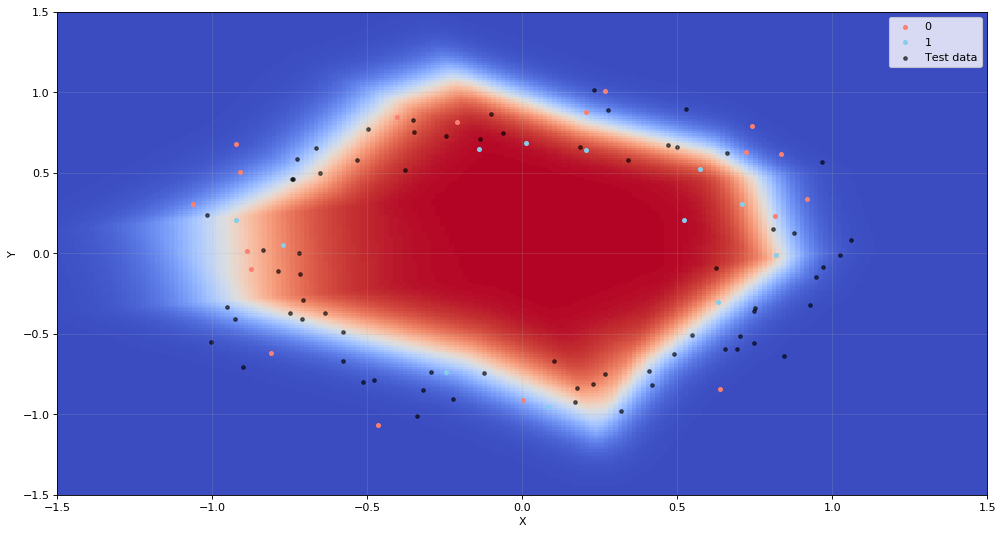

In [0]:
heat_map_predict(model_noise_in, x_lim=[-1.5, 1.5], y_lim=[-1.5, 1.5])

## 5.- Neural Network with Hidden Layer Noise

Now, we are going to try to create a Hidden Layer with Gaussian Noise. This has to be done before the activation function is applied. We will use a standard deviation of 0.1, again, chosen arbitrarily.

In [0]:
# Create model
model_noise_hid = Sequential()
# GaussianLayer with standard deviation of 0.1
model_noise_hid.add(Dense(400, input_dim = X_train.shape[1]))
model_noise_hid.add(GaussianNoise(0.1))
model_noise_hid.add(Activation('relu'))
model_noise_hid.add(Dense(1, activation='sigmoid'))
model_noise_hid.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_noise_hid.summary()

# Train model
hist_noise_hid = model_noise_hid.fit(X_train, y_train,
                                   validation_data=(X_test, y_test),
                                   epochs=5000, verbose=0)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 400)               1200      
_________________________________________________________________
gaussian_noise_2 (GaussianNo (None, 400)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 400)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 401       
Total params: 1,601
Trainable params: 1,601
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Evaluate the model with train and test sets
_, train_acc_noise_hid = model_noise_hid.evaluate(X_train, y_train, verbose=0)
_, test_acc_noise_hid = model_noise_hid.evaluate(X_test, y_test, verbose=0)

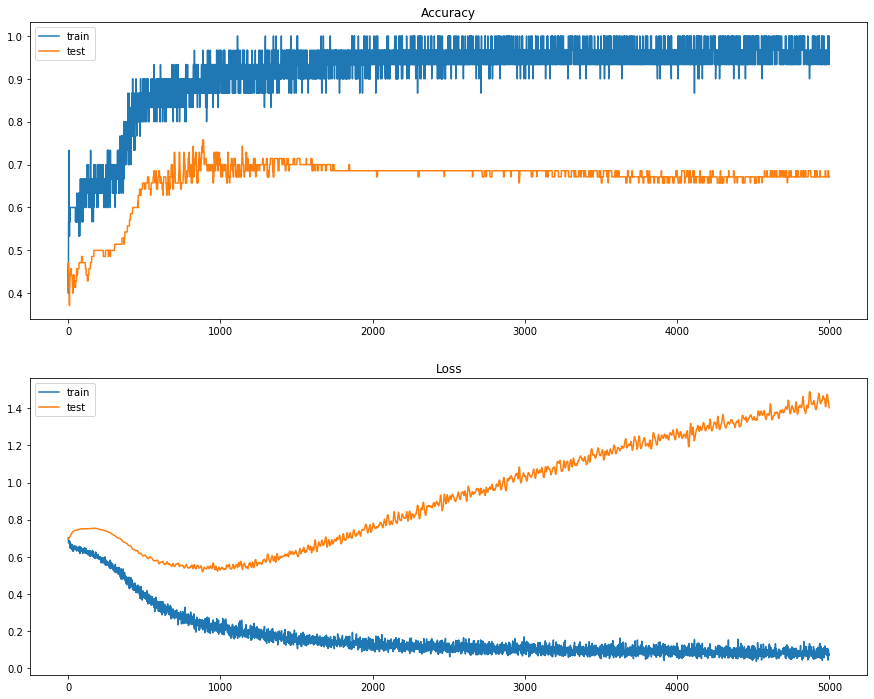

In [0]:
fig, axs = plt.subplots(2, figsize=(15, 12))

axs[0].plot(hist_noise_hid.history['acc'], label='train')
axs[0].plot(hist_noise_hid.history['val_acc'], label='test')
axs[0].title.set_text('Accuracy')
axs[0].legend()

axs[1].plot(hist_noise_hid.history['loss'], label='train')
axs[1].plot(hist_noise_hid.history['val_loss'], label='test')
axs[1].title.set_text('Loss')
axs[1].legend()

plt.show()

### Save result

In [0]:
# Insert results in dataframe
df_results_noise_hid = DataFrame({'Experiment': ['Hidden Noise Neural Network'], 
                      'train_acc': [train_acc_noise_hid],
                      'test_acc': [test_acc_noise_hid]})

df_results = df_results.append(df_results_noise_hid)

In [0]:
df_results

,Experiment,train_acc,test_acc
0,Basic Neural Network,1.000000,0.585714
0,Input Noise Neural Network,0.966667,0.642857
0,Hidden Noise Neural Network,0.966667,0.671429


In this case, it can be seen that `train_accuracy` remains constant, although we have got to increase the `test_accuracy`. It seems that adding __noise__ in our model allows improving the training of the neural network and is useful to mitigate overfitting.

### Heat-map Result

We plot the heat-map for `model_noise_hid`

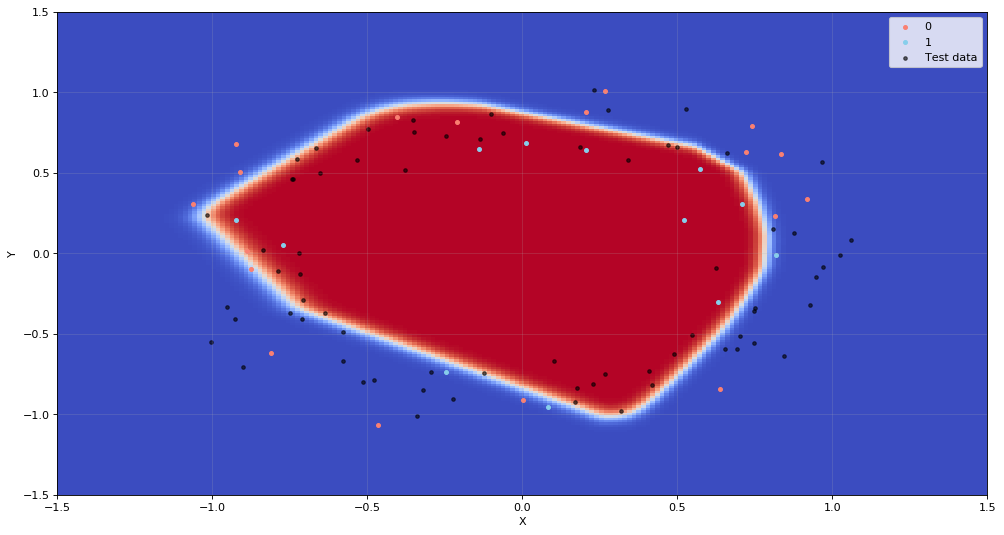

In [0]:
heat_map_predict(model_noise_hid, x_lim=[-1.5, 1.5], y_lim=[-1.5, 1.5])

## 6.- Neural Network with Input and Hidden Layer Noise

We have combined the 2 previous examples to study the performance of adding an `input layer noise` and a `hidden layer noise` at the same time. We will use a standard deviation of 0.1, again, chosen arbitrarily.

In [0]:
# Create model
model_noise_in_hid = Sequential()
# GaussianLayer with standard deviation of 0.1
model_noise_in_hid.add(GaussianNoise(0.1, input_shape=(2,)))
model_noise_in_hid.add(Dense(400, activation='relu'))
model_noise_in_hid.add(GaussianNoise(0.1))
model_noise_in_hid.add(Activation('relu'))
model_noise_in_hid.add(Dense(1, activation='sigmoid'))
model_noise_in_hid.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_noise_in_hid.summary()

# Train model
hist_noise_in_hid = model_noise_in_hid.fit(X_train, y_train,
                                           validation_data=(X_test, y_test),
                                           epochs=5000, verbose=0)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_3 (GaussianNo (None, 2)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 400)               1200      
_________________________________________________________________
gaussian_noise_4 (GaussianNo (None, 400)               0         
_________________________________________________________________
activation_2 (Activation)    (None, 400)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 401       
Total params: 1,601
Trainable params: 1,601
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Evaluate the model with train and test sets
_, train_acc_noise_in_hid = model_noise_in_hid.evaluate(X_train, y_train, verbose=0)
_, test_acc_noise_in_hid = model_noise_in_hid.evaluate(X_test, y_test, verbose=0)

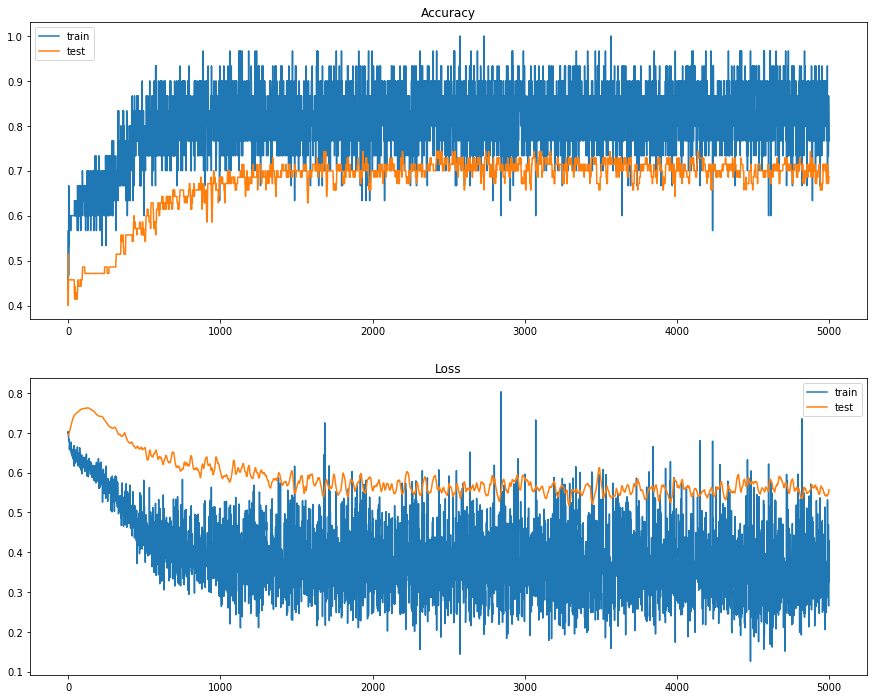

In [0]:
fig, axs = plt.subplots(2, figsize=(15, 12))

axs[0].plot(hist_noise_in_hid.history['acc'], label='train')
axs[0].plot(hist_noise_in_hid.history['val_acc'], label='test')
axs[0].title.set_text('Accuracy')
axs[0].legend()

axs[1].plot(hist_noise_in_hid.history['loss'], label='train')
axs[1].plot(hist_noise_in_hid.history['val_loss'], label='test')
axs[1].title.set_text('Loss')
axs[1].legend()

plt.show()

### Save result

In [0]:
# Insert results in dataframe
df_results_noise_in_hid = DataFrame({'Experiment': ['Input and Hidden Noise Neural Network'], 
                          'train_acc': [train_acc_noise_in_hid],
                          'test_acc': [test_acc_noise_in_hid]})

df_results = df_results.append(df_results_noise_in_hid)

In [0]:
df_results

,Experiment,train_acc,test_acc
0,Basic Neural Network,1.000000,0.585714
0,Input Noise Neural Network,0.966667,0.642857
0,Hidden Noise Neural Network,0.966667,0.671429
0,Input and Hidden Noise Neural Network,0.900000,0.685714


Again, it can be seen that with the use of noise as `input_layer` and `hidden_layer`, at the same time, we have got to reduce the overfitting in our model. Additionally, it has increased the `test_accuracy` and it seems that __Gaussian Noise__ as a regularization method allows the model to generalize better our data.

### Heat-map Result

We plot the heat-map for `model_noise_in_hid`

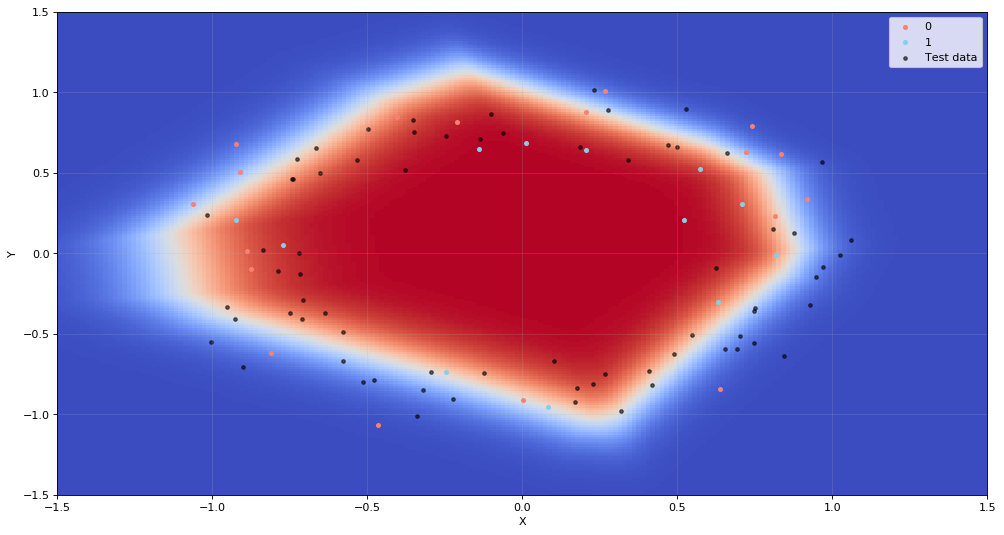

In [0]:
heat_map_predict(model_noise_in_hid, x_lim=[-1.5, 1.5], y_lim=[-1.5, 1.5])

## 7.- Grid Search

We are going to develop a __grid search__ to find the exact amount of noise and the nodes in the hidden layer that allows us to have the best performing model.

We will use the Neural Network with a Hidden Layer Noise as an example for the grid search. We need to create a function with the model to search for the best value for noise.

In [0]:
def create_model(nodes, noise_amount):

  # Create model
  model_noise_hid = Sequential()
  # GaussianLayer with standard deviation of 0.01
  model_noise_hid.add(Dense(nodes, input_dim = X_train.shape[1]))
  model_noise_hid.add(GaussianNoise(noise_amount))
  model_noise_hid.add(Activation('relu'))
  model_noise_hid.add(Dense(1, activation='sigmoid'))
  model_noise_hid.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model_noise_hid

We have defined a range of values for `noise_amount` and `nodes`

In [0]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

grid_values = {'noise_amount':[0.001, 0.01, 0.1, 0.2, 0.7, 1],
               'nodes': [50, 100, 300, 500]}

model = KerasClassifier(build_fn=create_model, epochs=5000, verbose=0, )

grid_model_hidden_acc = GridSearchCV(model, param_grid = grid_values)
grid_model_hidden_acc.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x7fdf31469fd0>,
             iid='deprecated', n_jobs=None,
             param_grid={'nodes': [50, 100, 300, 500],
                         'noise_amount': [0.001, 0.01, 0.1, 0.2, 0.7, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [0]:
print("Best: %f using %s" % (grid_model_hidden_acc.best_score_, grid_model_hidden_acc.best_params_))
means = grid_model_hidden_acc.cv_results_['mean_test_score']
stds = grid_model_hidden_acc.cv_results_['std_test_score']
params = grid_model_hidden_acc.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.833333 using {'nodes': 300, 'noise_amount': 0.001}
0.766667 (0.133333) with: {'nodes': 50, 'noise_amount': 0.001}
0.766667 (0.133333) with: {'nodes': 50, 'noise_amount': 0.01}
0.766667 (0.133333) with: {'nodes': 50, 'noise_amount': 0.1}
0.766667 (0.081650) with: {'nodes': 50, 'noise_amount': 0.2}
0.700000 (0.066667) with: {'nodes': 50, 'noise_amount': 0.7}
0.633333 (0.124722) with: {'nodes': 50, 'noise_amount': 1}
0.800000 (0.163299) with: {'nodes': 100, 'noise_amount': 0.001}
0.800000 (0.163299) with: {'nodes': 100, 'noise_amount': 0.01}
0.766667 (0.133333) with: {'nodes': 100, 'noise_amount': 0.1}
0.800000 (0.124722) with: {'nodes': 100, 'noise_amount': 0.2}
0.766667 (0.169967) with: {'nodes': 100, 'noise_amount': 0.7}
0.666667 (0.105409) with: {'nodes': 100, 'noise_amount': 1}
0.833333 (0.149071) with: {'nodes': 300, 'noise_amount': 0.001}
0.800000 (0.163299) with: {'nodes': 300, 'noise_amount': 0.01}
0.766667 (0.133333) with: {'nodes': 300, 'noise_amount': 0.1}
0.833333 (0.

We can see that the best results were achieved with a network with `300 neurons` in the hidden layer and with `noise_amount=0.001` with an accuracy of about 83%.

## 8.- Future Experiments

We can improve this experiment of adding noise as regularization method with the next ideas:
- Add more layers with noise to study his effect.
- Repeat the same experiments with a deeper neural network.
- Study the effect of noise as a regularization method in a model without overfitting.
- Try to add noise to activations, weights and outputs.